In [89]:
import pandas as pd 

data = pd.read_csv("../data/MLdata.csv")

data["Ship Date"] = pd.to_datetime(data["Ship Date"])
data["Order Date"] = pd.to_datetime(data["Order Date"])
data.head()

,Order Priority,Market,Segment,Category,Sub-Category,City,Country,Region,State,Ship Date,Order Date,Quantity,Discount,Sales,Shipping Cost,Ship Mode,Profit
0,Critical,US,Consumer,Technology,Accessories,New York City,United States,East,New York,2012-07-31,2012-07-31,7,0.0,2309.650,933.57,Same Day,762.1850
1,Critical,US,Consumer,Furniture,Tables,New York City,United States,East,New York,2012-07-31,2012-07-31,7,0.4,1090.780,348.18,Same Day,-290.8750
2,Critical,US,Consumer,Office Supplies,Paper,New York City,United States,East,New York,2012-07-31,2012-07-31,3,0.0,19.440,7.24,Same Day,9.3312
3,Critical,APAC,Corporate,Technology,Copiers,Wollongong,Australia,Oceania,New South Wales,2013-02-07,2013-02-05,2,0.1,344.682,65.35,Second Class,34.4220
4,Critical,APAC,Corporate,Office Supplies,Storage,Wollongong,Australia,Oceania,New South Wales,2013-02-07,2013-02-05,5,0.1,133.920,41.64,Second Class,-6.0300


In [94]:
# Shipping delay in days
df = data.copy()
df["Price Per Unit"] = data["Sales"] / data["Quantity"]
df["Ship Delay"] = (data["Ship Date"] - data["Order Date"]).dt.days

df["Ship Date Day"] = data["Ship Date"].dt.dayofyear
df["Order Date Day"] = data["Order Date"].dt.dayofyear

df["Ship Date Month"] = data["Ship Date"].dt.month
df["Order Date Month"] = data["Order Date"].dt.month

df["Ship Date Absolute"] = data["Ship Date"].map(lambda x: x.toordinal())
df["Ship Date Absolute"] = data["Order Date"].map(lambda x: x.toordinal())

df = df.drop(["Ship Date", "Order Date"], axis=1)

# Reordering Columns
df = df[['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category',
        'Region', 'Quantity',
        'Discount', 'Shipping Cost', 'Ship Delay', 'Ship Date Day',
        'Order Date Day', 'Ship Date Month', 'Order Date Month',
        'Ship Date Absolute', "Sales","Price Per Unit", 'Ship Mode', 'Profit']]

df.head()

,Order Priority,Market,Segment,Category,Sub-Category,Region,Quantity,Discount,Shipping Cost,Ship Delay,Ship Date Day,Order Date Day,Ship Date Month,Order Date Month,Ship Date Absolute,Sales,Price Per Unit,Ship Mode,Profit
0,Critical,US,Consumer,Technology,Accessories,East,7,0.0,933.57,0,213,213,7,7,734715,2309.650,329.950000,Same Day,762.1850
1,Critical,US,Consumer,Furniture,Tables,East,7,0.4,348.18,0,213,213,7,7,734715,1090.780,155.825714,Same Day,-290.8750
2,Critical,US,Consumer,Office Supplies,Paper,East,3,0.0,7.24,0,213,213,7,7,734715,19.440,6.480000,Same Day,9.3312
3,Critical,APAC,Corporate,Technology,Copiers,Oceania,2,0.1,65.35,2,38,36,2,2,734904,344.682,172.341000,Second Class,34.4220
4,Critical,APAC,Corporate,Office Supplies,Storage,Oceania,5,0.1,41.64,2,38,36,2,2,734904,133.920,26.784000,Second Class,-6.0300


In [95]:
from sklearn.model_selection import train_test_split

x_profit = df.drop(["Profit"], axis=1)
y_profit = df["Profit"]

xp_train, xp_test, yp_train, yp_test = train_test_split(x_profit, y_profit, test_size=0.2, random_state=42)

In [100]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# One Hot Encoder for non numeric features
ct = ColumnTransformer([
#    ("onehot", OneHotEncoder(), ['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category', 'Region', 'Ship Mode']),
    ("encoder", OrdinalEncoder(), ['Sub-Category']),
    ("scalar", StandardScaler(), ["Shipping Cost", "Sales", "Price Per Unit"]),
    ("passthorugh", 'passthrough', ["Discount", "Ship Date Absolute", "Quantity"])
])

model_profit = Pipeline(steps=[
    ("ct", ct),
    ("regressor", RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=100))
])

model_profit.fit(xp_train, yp_train)

yp_pred = model_profit.predict(xp_test)

profit_r2 = r2_score(yp_test, yp_pred)
profit_mse = mean_squared_error(yp_test, yp_pred)


print(f"R2 score: {profit_r2}")
print(f"MSE: {profit_mse}")

R2 score: 0.7378204170101972
MSE: 6570.86803750282


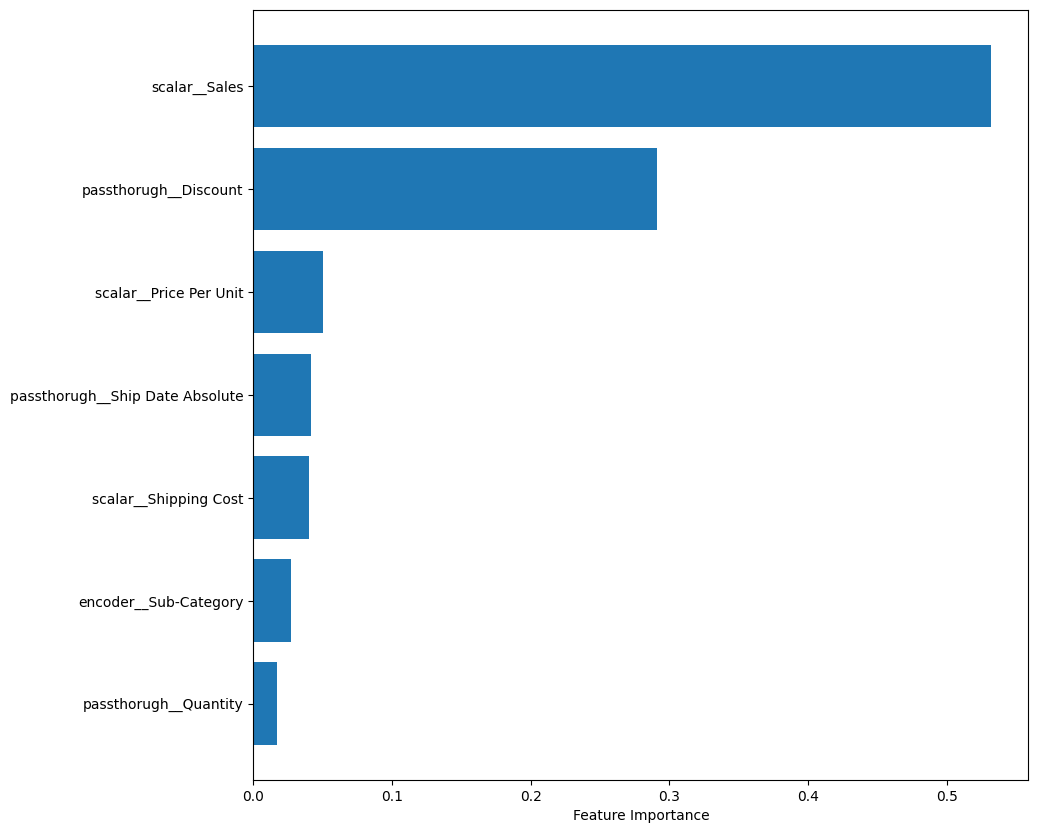

In [97]:
importance = model_profit.named_steps["regressor"].feature_importances_
features = model_profit.named_steps["ct"].get_feature_names_out()
feature_imp = pd.DataFrame(importance, features, columns=["Importance"])
feature_imp = feature_imp.sort_values("Importance", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(feature_imp.index, feature_imp["Importance"])
plt.xlabel("Feature Importance")
plt.show()